In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.
Metal device set to: Apple M1


2023-02-28 14:21:06.012483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-28 14:21:06.013006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

2023-02-28 14:21:10.304672: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


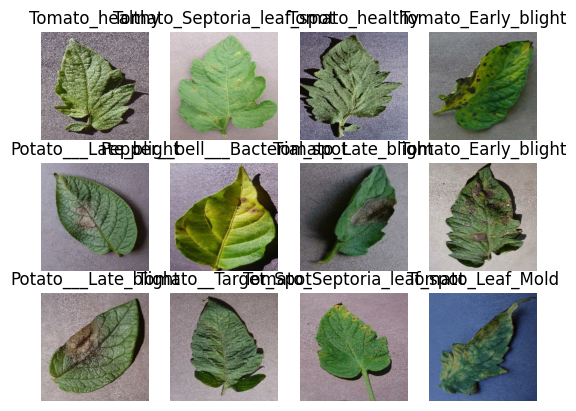

In [5]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def dataset_partitions(ds, train_split=0.8, valid_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    assert (train_split + test_split + valid_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    valid_size = int(valid_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds, valid_ds, test_ds

In [7]:
train_ds, valid_ds, test_ds = dataset_partitions(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      layers.experimental.preprocessing.RandomRotation(0.2),
    ])

In [11]:
with tf.device('/cpu:0'):
    train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [14]:
with tf.device("/gpu:0"):
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

In [15]:
with tf.device("/gpu:0"):
    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=25,
    )

Epoch 1/25


2023-02-28 14:21:43.565353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-28 14:21:53.648328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 520 of 1000
2023-02-28 14:21:58.569938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-02-28 14:21:58.571396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-02-28 14:21:58.707195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


516/516 [==============================] - ETA: 0s - loss: 2.1589 - accuracy: 0.2814

2023-02-28 14:24:46.915136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-28 14:24:57.620431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 381 of 1000
2023-02-28 14:25:06.972995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 498 of 1000
2023-02-28 14:25:16.968802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 594 of 1000
2023-02-28 14:25:24.653541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-02-28 14:25:25.628617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-02-28 14:25:25.628645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 

516/516 [==============================] - 246s 439ms/step - loss: 2.1589 - accuracy: 0.2814 - val_loss: 1.7594 - val_accuracy: 0.4292
Epoch 2/25
516/516 [==============================] - 148s 284ms/step - loss: 1.5356 - accuracy: 0.4892 - val_loss: 1.3658 - val_accuracy: 0.5410
Epoch 3/25
516/516 [==============================] - 156s 301ms/step - loss: 1.1039 - accuracy: 0.6266 - val_loss: 1.7814 - val_accuracy: 0.5068
Epoch 4/25
516/516 [==============================] - 158s 296ms/step - loss: 0.8208 - accuracy: 0.7189 - val_loss: 1.1105 - val_accuracy: 0.6655
Epoch 5/25
516/516 [==============================] - 155s 300ms/step - loss: 0.6262 - accuracy: 0.7840 - val_loss: 0.6852 - val_accuracy: 0.7637
Epoch 6/25
516/516 [==============================] - 158s 306ms/step - loss: 0.5143 - accuracy: 0.8201 - val_loss: 1.1273 - val_accuracy: 0.6699
Epoch 7/25
516/516 [==============================] - 174s 335ms/step - loss: 0.4553 - accuracy: 0.8405 - val_loss: 0.7545 - val_accura

2023-02-28 15:42:36.429619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 281 of 1000
2023-02-28 15:42:47.253403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 402 of 1000
2023-02-28 15:42:56.427734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 544 of 1000
2023-02-28 15:43:06.269988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-02-28 15:43:08.124444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-02-28 15:43:08.124460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 1000
2023-02-28 15:43:08.124464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 1000
202

first image to predict
actual label: Tomato_Septoria_leaf_spot


2023-02-28 15:43:20.566485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step
predicted label: Tomato_Septoria_leaf_spot


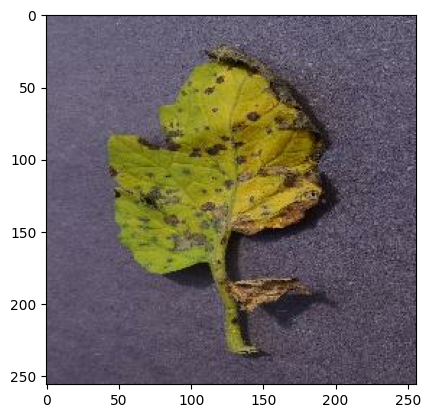

In [17]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [18]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

2023-02-28 15:45:42.218038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


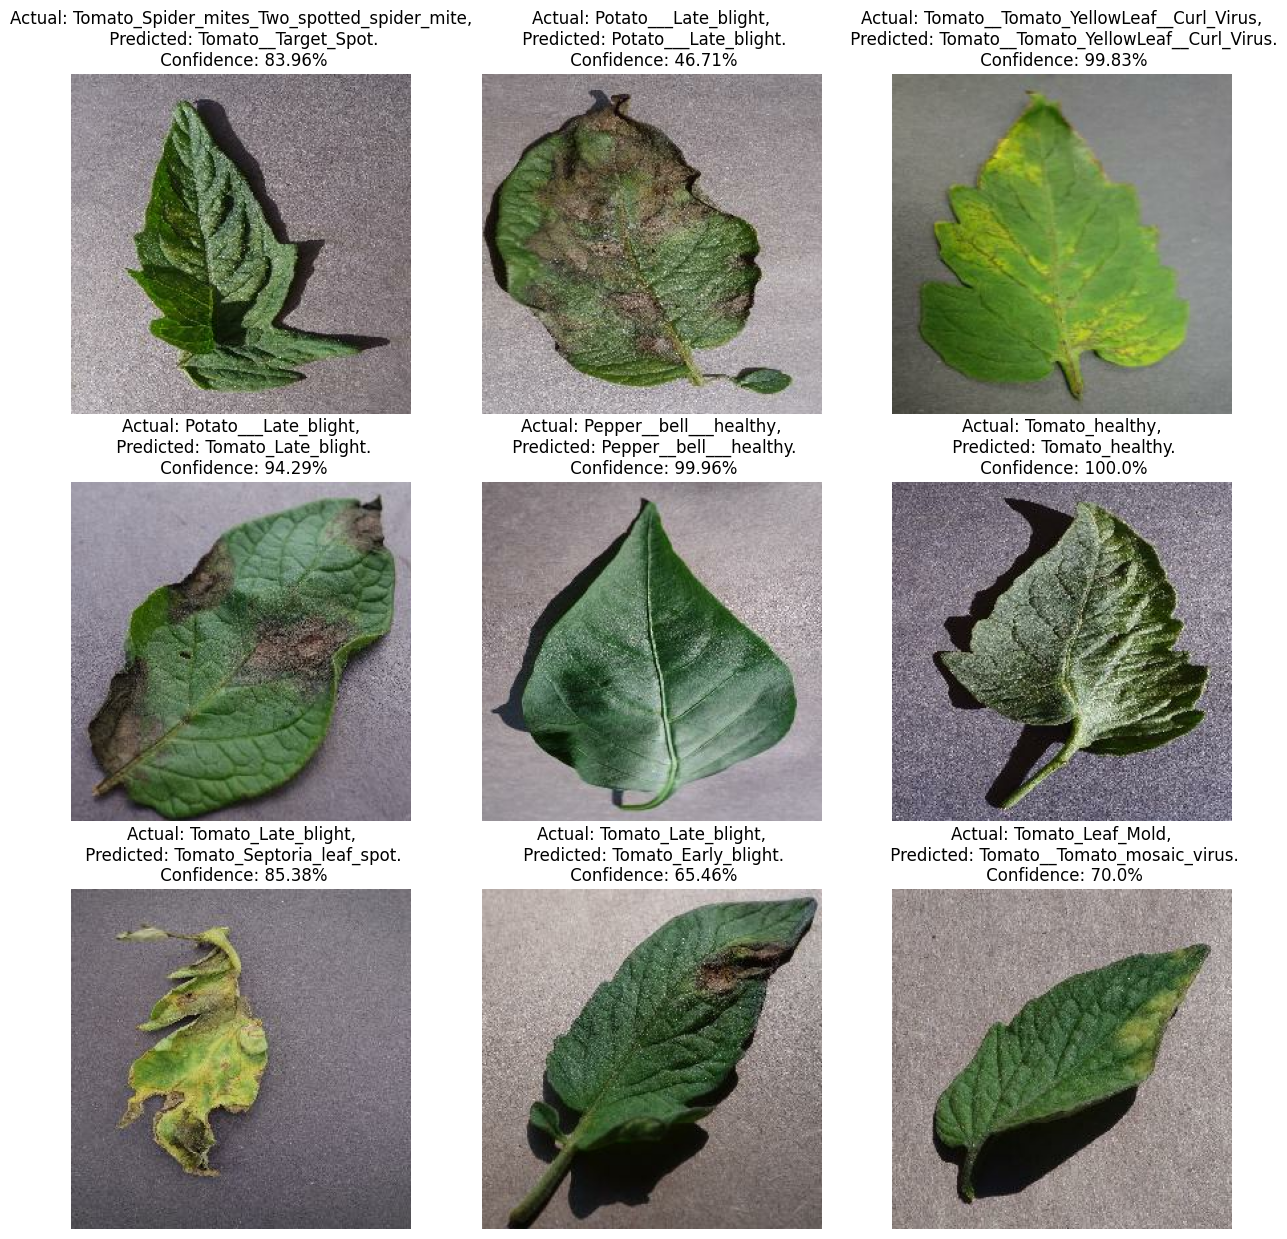

In [19]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [21]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets


In [22]:
model.save("../plantio.h5")